In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

import numpy as np
import json

In [ ]:
#TEST COMMIT

In [ ]:
f = open('tokens.json')
json_keys = json.load(f)

In [ ]:
json_keys['telegram_risk_chat_id']

'1002290657598'

In [ ]:
COIN_GECKO_API_KEY = json_keys['coin_gecko_api_token']

In [ ]:

def get_historical_prices_coingecko(coin_id="avalanche-2", currency="usd", days="365", api_key=''):
    url = f"https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart"

    params = {
        "vs_currency": currency,
        "days": days,
        "interval": "daily"}
    headers = {
        "accept": "application/json",
        "x-cg-pro-api-key": api_key
    }

    response = requests.get(url, params=params,headers=headers)
    data = response.json()

    if "prices" in data:
        df = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        df['daily_returns'] = np.log(df.price/df.price.shift(1))
        df.loc[:,'weeekday'] = df.timestamp.dt.weekday
        return df
    else:
        print("Error fetching data:", data)
        return None


def create_position(qty_avax, qty_iterations, avax_btc, ltv, yield_avax, yield_btc):

    qty_avax_total = qty_avax
    qty_btc_in_avax = 0
    qty_btc = 0
    df_data = []

    # Set a Target LTV
    for i in range(1, qty_iterations+1):

        qty_btc_in_avax += qty_avax*(ltv**i)
        qty_avax_total += qty_avax*(ltv**i)
        qty_btc = qty_btc_in_avax/avax_btc
        df_data.append([qty_avax, qty_avax_total-qty_avax, -qty_btc, -qty_btc_in_avax, yield_avax, yield_btc])

    df = pd.DataFrame(
        data=df_data,
        columns=[
            'LONG_AVAX_ORIGINAL', 'LONG_AVAX_LEND', 'SHORT_BTC_BORROW',
            'SHORT_BTC_IN_AVAX', 'YIELD_AVAX', 'YIELD_BTC'],

    )

    df['HEALTH'] = df[['LONG_AVAX_ORIGINAL', 'LONG_AVAX_LEND']].sum(1)/df.SHORT_BTC_IN_AVAX
    df['LIQUIDATION_PRICE'] = -df[['LONG_AVAX_ORIGINAL', 'LONG_AVAX_LEND']].sum(1)/df.SHORT_BTC_BORROW

    return df

def merge_returns(df_avax,df_btc):

    df_avax_btc = pd.merge(
        left=df_avax.set_index('timestamp')['price'],
        right=df_btc.set_index('timestamp')['price'],
        left_index=True,
        right_index=True,
        how='inner',
        suffixes=('_avax', '_btc'))

    df_avax_btc['avax_btc'] = df_avax_btc.price_avax/df_avax_btc.price_btc

    return df_avax_btc


def rolling_analysis(df_avax_btc, window):

    _df_avax_btc = df_avax_btc.copy()

    _df_avax_btc[f'rolling_corr_{window}'] = _df_avax_btc['price_btc'].rolling(window).corr(
        _df_avax_btc['price_avax'])

    _df_avax_btc[f'total_avax_return'] = _df_avax_btc['avax_btc'].rolling(window).agg(
        lambda rows: rows.iloc[-1]/rows.iloc[0] - 1)

    _df_avax_btc[f'total_avax_log_return'] = _df_avax_btc['avax_btc'].rolling(window).agg(
        lambda rows: np.log(rows.iloc[-1]/rows.iloc[0]))

    _df_avax_btc[f'worst_avax_return'] = _df_avax_btc['avax_btc'].rolling(window).apply(
        lambda row: row.min()/row.iloc[0] - 1)

    return _df_avax_btc


def leveraged_results(df_avax_btc_rolling, initial_ltv):

    df = df_avax_btc_rolling

    df['final_health_factor'] = (1+df['total_avax_return'])/initial_ltv
    df['final_ltv'] = 1/df['final_health_factor']

    df['worst_health_factor'] = (1+df['worst_avax_return'])/initial_ltv
    df['worst_ltv'] = 1/df['worst_health_factor']

    df = df[['final_ltv', 'final_health_factor', 'worst_health_factor', 'worst_ltv']]

    return df



def agg_leveraged_results(df_avax_btc_rolling, array_initial_ltv):

    df_final_ltv = pd.DataFrame(index=df_avax_btc_rolling.index)
    df_worst_ltv = pd.DataFrame(index=df_avax_btc_rolling.index)

    for ltv in array_initial_ltv:

        df_final_ltv[ltv] = leveraged_results(df_avax_btc_rolling, initial_ltv=ltv).final_ltv
        df_worst_ltv[ltv] = leveraged_results(df_avax_btc_rolling, initial_ltv=ltv).worst_ltv

    return df_final_ltv, df_worst_ltv




In [ ]:
df_avax = get_historical_prices_coingecko(coin_id="avalanche-2", currency="usd", days="1500", api_key=COIN_GECKO_API_KEY)
df_btc = get_historical_prices_coingecko(coin_id="bitcoin", currency="usd", days="1500", api_key=COIN_GECKO_API_KEY)

df_avax_btc = merge_returns(df_avax,df_btc)

df_avax_btc_rolling = rolling_analysis(
    df_avax_btc,
    180)

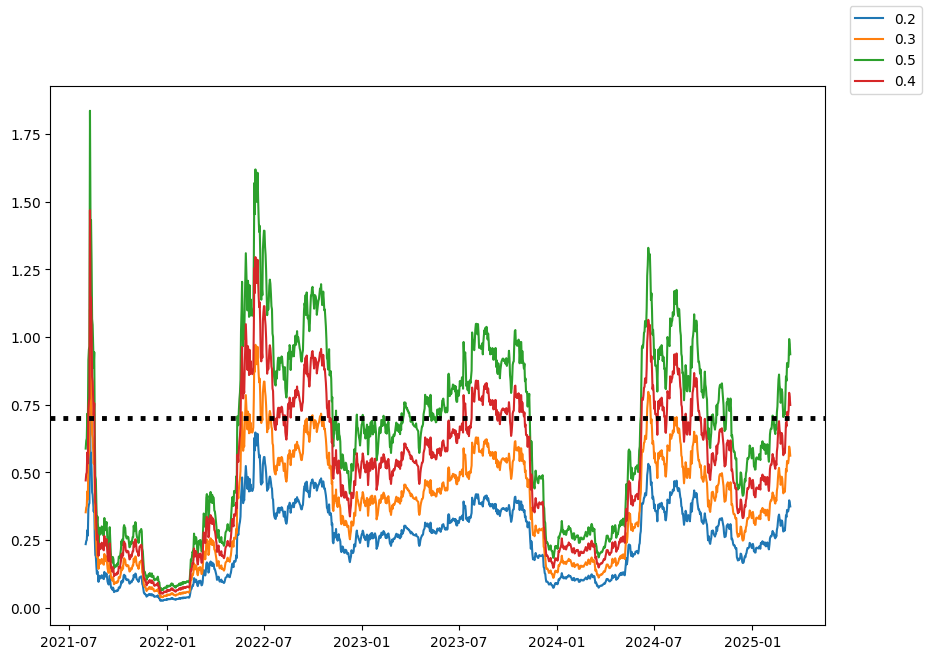

In [ ]:
df_to_plot = agg_leveraged_results(df_avax_btc_rolling, [.2,.3,.5,.4])[0]
fig, ax = plt.subplots(figsize=(10,7))

for col in df_to_plot.columns:
    ax.plot(df_to_plot.index, df_to_plot[col], label=str(col))

ax.axhline(y=0.7, color='black', linestyle='dotted', linewidth=3.5)
fig.legend()

plt.show()

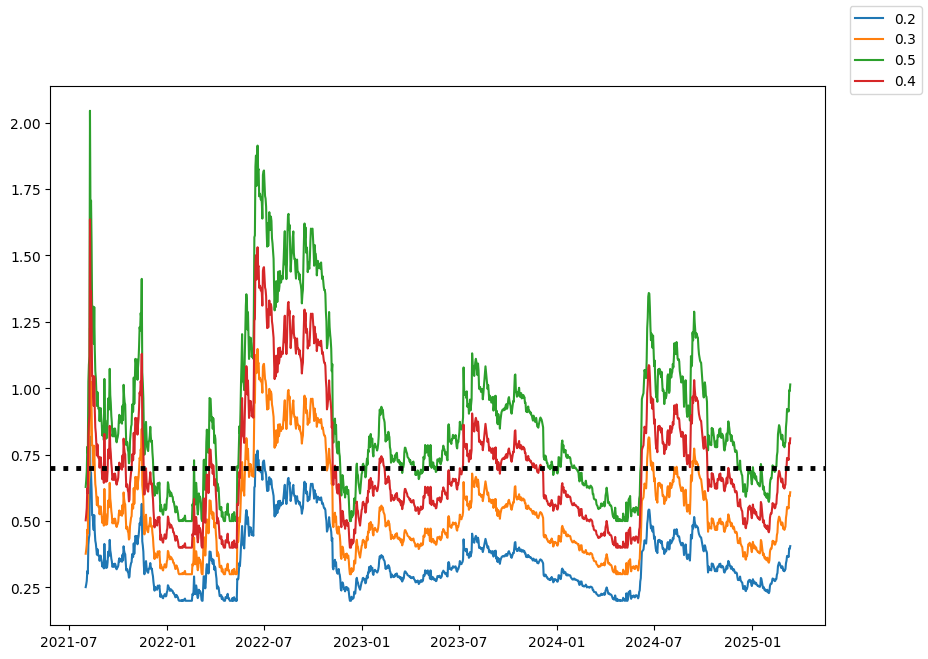

In [ ]:
df_to_plot = agg_leveraged_results(df_avax_btc_rolling, [.2,.3,.5,.4])[1]
fig, ax = plt.subplots(figsize=(10,7))

for col in df_to_plot.columns:
    ax.plot(df_to_plot.index, df_to_plot[col], label=str(col))

ax.axhline(y=0.7, color='black', linestyle='dotted', linewidth=3.5)
fig.legend()

plt.show()

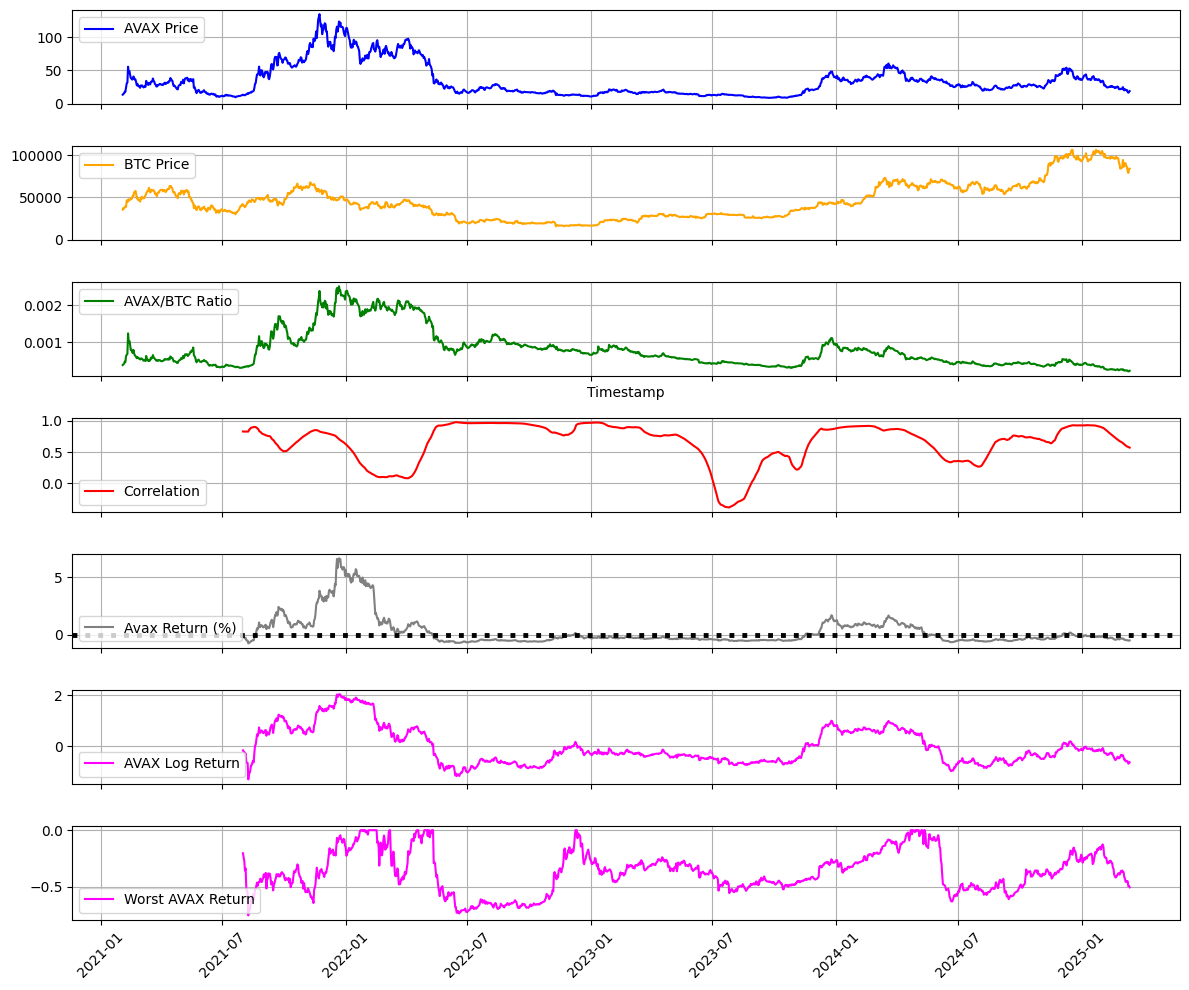

In [ ]:

# Plot three line plots sharing the same x-axis
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12, 10), sharex=True)

# Plot price_avax
axes[0].plot(
    df_avax_btc_rolling.index,
    df_avax_btc_rolling['price_avax'],
    label='AVAX Price',
    color='blue')

axes[0].legend(loc= 'upper left')
axes[0].set_ylim(ymin=0)
axes[0].grid()

# Plot price_btc
axes[1].plot(
    df_avax_btc_rolling.index,
    df_avax_btc_rolling['price_btc'],
    label='BTC Price',
    color='orange')

axes[1].set_ylim(ymin=0)
axes[1].legend()
axes[1].grid()

# Plot avax_btc ratio
axes[2].plot(
    df_avax_btc_rolling.index,
    df_avax_btc_rolling['avax_btc'],
    label='AVAX/BTC Ratio',
    color='green')

axes[2].set_xlabel('Timestamp')
axes[2].legend(loc= 'upper left')
axes[2].grid()

# Plot avax_btc ratio
axes[3].plot(
    df_avax_btc_rolling.index,
    df_avax_btc_rolling['rolling_corr_180'],
    label='Correlation',
    color='red')

axes[3].legend(loc= 'lower left')
axes[3].grid()

# Plot avax_btc ratio
axes[4].plot(
    df_avax_btc_rolling.index,
    df_avax_btc_rolling['total_avax_return'],
    label='Avax Return (%)',
    color='grey')

axes[4].legend(loc= 'lower left')
axes[4].axhline(y=0.0, color='black', linestyle='dotted', linewidth=3.5)
axes[4].grid()


# Plot avax_btc ratio
axes[5].plot(
    df_avax_btc_rolling.index,
    df_avax_btc_rolling['total_avax_log_return'],
    label='AVAX Log Return',
    color='magenta')

axes[5].legend(loc= 'lower left')
axes[5].grid()

# Plot avax_btc ratio
axes[6].plot(
    df_avax_btc_rolling.index,
    df_avax_btc_rolling['worst_avax_return'],
    label='Worst AVAX Return',
    color='magenta')

axes[6].legend(loc= 'lower left')
axes[6].grid()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def historical_long_short(df_avax_btc_rolling, start_date, window, initial_ltv, threshold_ltv):

    start_index = df_avax_btc_rolling.index.get_loc(start_date)
    end_index = start_index + window

    df = df_avax_btc_rolling.iloc[start_index:end_index].copy()
    df = df[['price_avax', 'price_btc', 'avax_btc']]

    df['long_avax'] = np.nan
    df['short_btc'] = np.nan
    df['ltv'] = np.nan

    df.loc[df.index[0],'long_avax'] = 1.0
    df.loc[df.index[0],'short_btc'] = initial_ltv
    df.loc[df.index[0],'ltv'] = initial_ltv

    initial_avax_btc = df.loc[df.index[0],'avax_btc']

    for i in range(1, window):

        loop_dt = df.index[i]
        loop_dt_d1 = df.index[i - 1]

        previous_ltv = df.loc[loop_dt_d1,'ltv']

        if previous_ltv < threshold_ltv:

            df.loc[loop_dt,'long_avax'] = df.loc[loop_dt_d1,'long_avax']
            df.loc[loop_dt,'short_btc'] = initial_ltv*initial_avax_btc/df.loc[loop_dt,'avax_btc']
            df.loc[loop_dt,'ltv'] = df.loc[loop_dt,'short_btc']/df.loc[loop_dt,'long_avax']

        else:

            df.loc[loop_dt,'short_btc'] = initial_ltv*initial_avax_btc/df.loc[loop_dt,'avax_btc']
            df.loc[loop_dt,'long_avax'] = df.loc[loop_dt,'short_btc']/initial_ltv
            df.loc[loop_dt,'ltv'] = df.loc[loop_dt,'short_btc']/df.loc[loop_dt,'long_avax']

    df = df[['long_avax', 'short_btc', 'ltv']]

    return df


In [ ]:
def scenarios_long_short(df_avax_btc_rolling, window, initial_ltv, threshold_ltv):

    date_index = df_avax_btc_rolling.index[:-window]

    df_ltv = pd.DataFrame(
        index=date_index,
        columns=range(window))

    df_top_ups = pd.DataFrame(
        index=date_index,
        columns=range(window))

    for start_date in date_index:

        df = historical_long_short(
            df_avax_btc_rolling=df_avax_btc_rolling,
            start_date=start_date,
            window=window,
            initial_ltv=initial_ltv,
            threshold_ltv=threshold_ltv)

        df_ltv.loc[start_date] = df.ltv.values
        df_top_ups.loc[start_date] = df.long_avax.diff().fillna(0).values

    return df_ltv, df_top_ups

In [ ]:
df_ltv, df_top_ups = scenarios_long_short(
    df_avax_btc_rolling=df_avax_btc_rolling,
    window=180,
    initial_ltv=.3,
    threshold_ltv=.4
)

In [ ]:
df_top_ups_sum = df_top_ups.sum(1)

<Axes: xlabel='timestamp'>

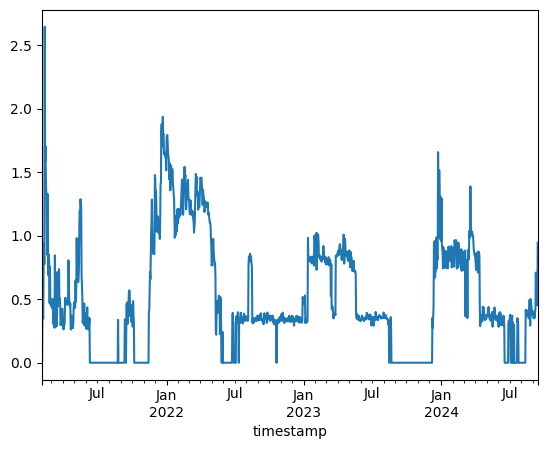

In [ ]:
df_top_ups_sum.plot()

<Axes: ylabel='Density'>

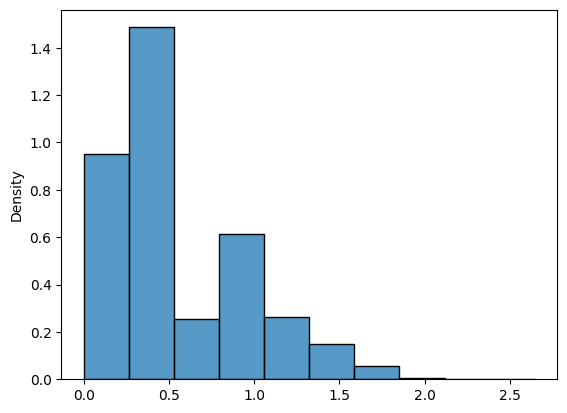

In [ ]:
fig, ax = plt.subplots()

data = df_top_ups_sum

bins = np.histogram(
    data,
    bins=10)[1]

bins = [float(x) for x in bins]

sns.histplot(
    data,stat='density',
    bins=10,
    ax=ax)

In [ ]:
counts, bin_edges = np.histogram(data,bins=10,density=True)

counts = counts/counts.sum()

In [ ]:
df_hist = pd.DataFrame(
    data=counts*100,
    index=[(np.round(x,2),np.round(y,2)) for x,y in zip(bins[:-1],bins[1:])])

df_hist.index.name = 'bins'
df_hist.columns = ['implied_prob']

In [ ]:
[(np.round(x,2),np.round(y,2)) for x,y in zip(bins[:-1],bins[1:])]

[(np.float64(0.0), np.float64(0.26)),
 (np.float64(0.26), np.float64(0.53)),
 (np.float64(0.53), np.float64(0.79)),
 (np.float64(0.79), np.float64(1.06)),
 (np.float64(1.06), np.float64(1.32)),
 (np.float64(1.32), np.float64(1.59)),
 (np.float64(1.59), np.float64(1.85)),
 (np.float64(1.85), np.float64(2.12)),
 (np.float64(2.12), np.float64(2.38)),
 (np.float64(2.38), np.float64(2.65))]

In [ ]:
pd.options.display.float_format = "{:,.2f}".format


In [ ]:
df_hist

,implied_prob
bins,
"(0.0, 0.26)",25.15
"(0.26, 0.53)",39.32
"(0.53, 0.79)",6.74
"(0.79, 1.06)",16.21
"(1.06, 1.32)",6.97
"(1.32, 1.59)",3.94
"(1.59, 1.85)",1.44
"(1.85, 2.12)",0.15
"(2.12, 2.38)",0.00
